# First steps

NOTE:
- Fissata versione di python 3.9
- Salvati i requirements.txt con versioni pacchetti per rendere riproducibile il tutto
- Aggiunto template/esercizio per custom transformation
- Aggunta doppia versione di sanitazation in numpy e pytorch evidenziando le criticità
- Menzionare da dove vengono i valori di T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
- Spiegare perchè è commentato T.ToTensor() ovvero perchè non sempre si vuole la normalizzazione 0 1
- Tolto __load_subset_item che non è usato
- Aggiunto nn.Module alla classe GMNISTClassifier
- Semplificato e suddiviso GMNISTClassifier, troppo pesante.


Idee/dubbi/proposte:
- Aggiungere immagini delle classi di galaxyMNIST nel markdown dove si spiega il dataset?
- Toglierei alcune transforms già implementate in torchvision (tipo rotation e flip) e lascerei quella dei NaN o ne implementerei comunque una ad hoc
- Far vedere le varie trasformazioni (in altro notebook magari)
- Considerare di separare il notebook: uno che runna la pipeline senza troppi dettagli e dei notebook specialistici (transforms, train loop, NN architecture...). Che non si sovrapponga con le cose di S.Palazzo
- Dobbiamo fargli setuppare WANDB? o possiamo presettare noi l'ambiente e farli loggare in progetti nome-cognome?
- Fornire notebook con errori da debuggare? (magari nel tutorial sulle best practice)

## Module installation
Let's first install required python modules.

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
###########################
##   LOGGING
###########################
import logging
import logging.config

# Create the Logger
logging.basicConfig(format="%(asctime)-15s %(levelname)s - %(message)s",datefmt='%Y-%m-%d %H:%M:%S')
logger= logging.getLogger("gmnist-classifier")
logger.setLevel(logging.INFO)

### Project folders

In [3]:
import os
from pathlib import Path

def create_dir(dirname):
    logger.info("Creating directory %s ..." % (dirname))
    path = Path(dirname)
    path.mkdir(parents=True, exist_ok=True)
    logger.info("Run directory %s created successfully ..." % (dirname))

# - Set project directory
topdir= os.getcwd()
logger.info("topdir=%s" % (topdir))

############################
##   DATASET URL
############################
dataset_name= "galaxy_mnist-dataset"
dataset_dir= os.path.join(topdir, dataset_name)
dataset_filename= 'galaxy_mnist-dataset.tar.gz'
dataset_url= 'https://drive.google.com/uc?export=download&id=1OprJ_NQIFyQSRWqjGLFQsAMumHvJ-tMB'
filename_train= os.path.join(dataset_dir, "train/1chan/datalist_train.json")
filename_test= os.path.join(dataset_dir, "test/1chan/datalist_test.json")
filename_train_3chan= os.path.join(dataset_dir, "train/3chan/datalist_train.json")
filename_test_3chan= os.path.join(dataset_dir, "test/3chan/datalist_test.json")

2025-03-14 18:03:03 INFO - topdir=/home/thomas/usc8-ai-workshop


# Dataset
For this tutorial, we are going to use the Galaxy MNIST dataset [https://github.com/mwalmsley/galaxy_mnist]. We have slighly modified the format for this tutorial. The modified dataset is available for download in Google Drive.

The dataset currently contains 10,000 images of galaxies in three optical bands, either low3x64x64 (low reso) or 3x224x224 (high reso), taken from the Galaxy Zoo project. The dataset is split into two subsets: 

- train: 8000 images
- test: 2000 images

The dataset contains 4 possible classes of galaxy morphologies:

- SMOOTH_ROUND: smooth and round galaxy. Should not have signs of spires.   
- SMOOTH_CIGAR: smooth and cigar-shaped galaxy, looks like being seen edge on. This should not have signs of spires of a spiral galaxy.
- EDGE_ON_DISK: edge-on-disk/spiral galaxy. This disk galaxy should have signs of spires, as seen from an edge-on perspective.
- UNBARRED_SPIRAL: unbarred spiral galaxy. Has signs of a disk and/or spires

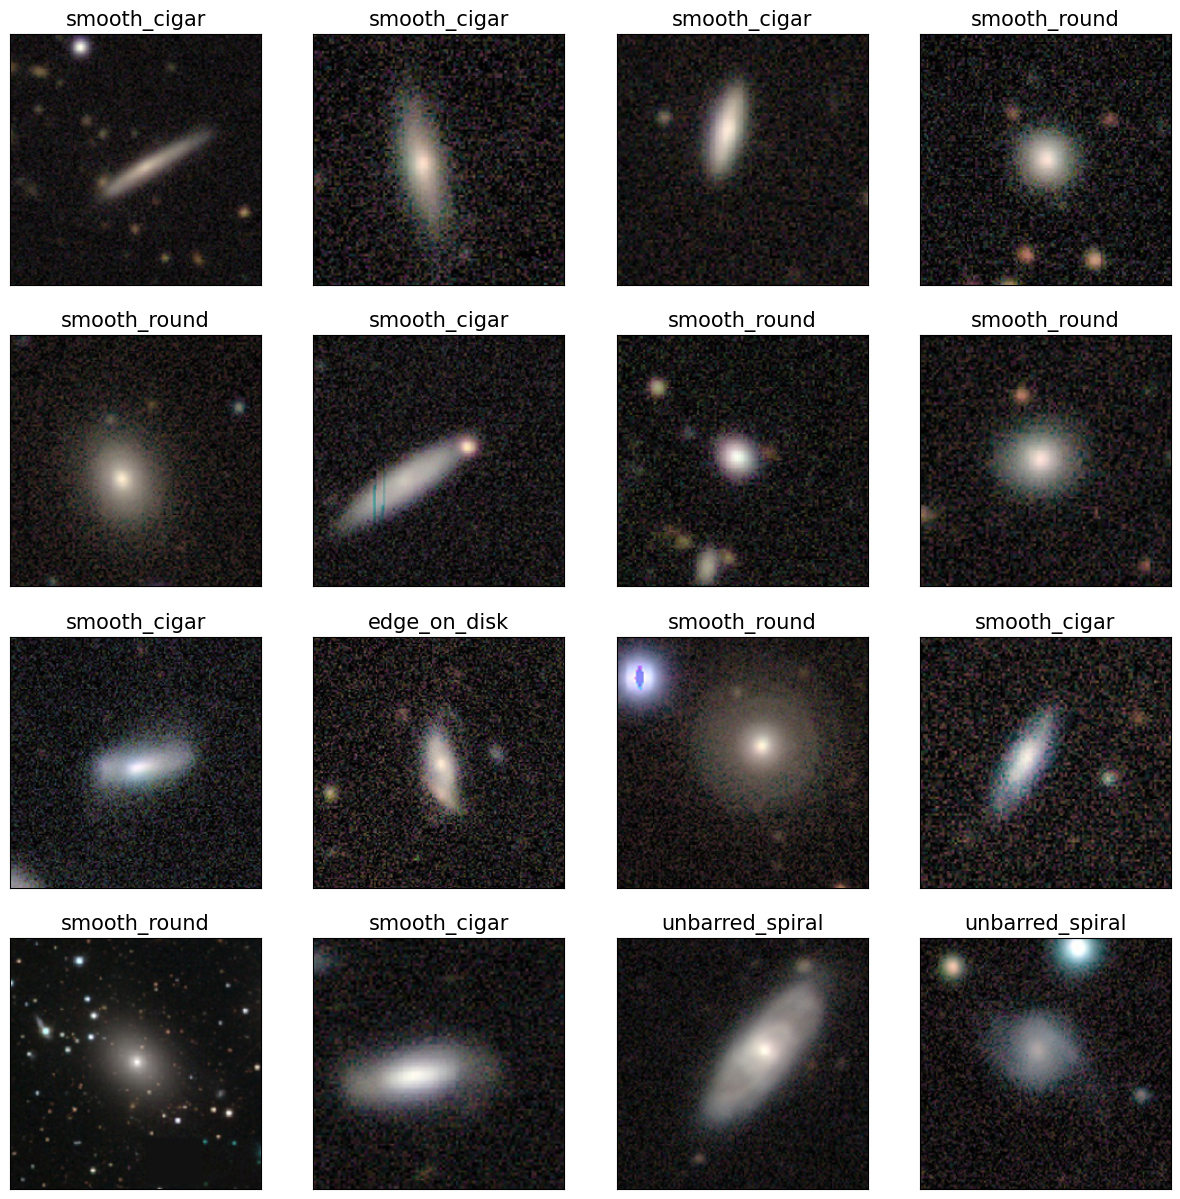

Note that categories SMOOTH_CIGAR and EDGE_ON_DISK classes tend to be very similar to each other. To categorize them, ask yourself the following question: Is this galaxy very smooth, maybe with a small bulge? Then it belongs to class SMOOTH_CIGAR. Does it have irregularities/signs of structure? Then it belongs to class EDGE_ON_DISK.

## Dataset Download
We download the dataset from GoogleDrive and unzip it in the main folder.

In [4]:
import os
import gdown
import tarfile

#################################
##      DOWNLOAD FILES
#################################
def download_files_from_gdrive(url, outfile, force=False):
  """ Download model file from gDrive """

  if force or not os.path.isfile(outfile):
    gdown.download(url, outfile, quiet=False)
   
def untar_file(filename):
  """ Unzip file """
  
  fp= tarfile.open(filename)
  fp.extractall('.')
  fp.close()  

# - Enter top directory
os.chdir(topdir)

# - Download dataset
logger.info("Downloading file from url %s ..." % (dataset_url))
download_files_from_gdrive(dataset_url, dataset_filename, force=False)
logger.info("DONE!")

# - Untar dataset
logger.info("Unzipping dataset file %s ..." % (dataset_filename))
untar_file(dataset_filename)
logger.info("DONE")

2025-03-14 18:03:03 INFO - Downloading file from url https://drive.google.com/uc?export=download&id=1OprJ_NQIFyQSRWqjGLFQsAMumHvJ-tMB ...
2025-03-14 18:03:03 INFO - DONE!
2025-03-14 18:03:03 INFO - Unzipping dataset file galaxy_mnist-dataset.tar.gz ...
2025-03-14 18:03:12 INFO - DONE


## Create PyTorch Dataset
Let's create a custom pytorch dataset using base VisionDataset. 

In [5]:
import numpy as np
import torch
from torch.utils.data import Dataset, Subset, random_split
from torchvision.datasets.vision import VisionDataset
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.transforms import ToTensor
import PIL
from PIL import Image
import json
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from itertools import islice
import random
import matplotlib.pyplot as plt

#################################
##      DATASET
#################################
class GMNISTDataset(Dataset):
  """ Galaxy MNIST dataset """

  def __init__(
      self, 
      metadata_file: Optional[Union[str, Path]] = "",
      subset: Optional[Subset] = None,
      transform: Optional[Callable] = None,
      target_transform: Optional[Callable] = None,
  ):
    """
      Arguments:
        metadata_file (string): Path to the json file with annotations.
        transform (callable, optional): Optional transform to be applied on a sample.
    """
    
    self.subset= subset
    if self.subset is None:
        logger.info("Reading dataset metadata from file %s ..." % (metadata_file))
        self.__read_metadata(metadata_file)
        
    self.transform = transform
    self.target_transform = target_transform
    self.pil2tensor = T.Compose([T.PILToTensor()]) # no normalization
    #self.pil2tensor = T.Compose([T.ToTensor()]) # normalize in [0,1] assuming max=255
    
    self.target2label= {
      0: "smooth_round",  
      1: "smooth_cigar",
      2: "edge_on_disk",
      3: "unbarred_spiral"
    }

  def __read_metadata(self, filename):
    """ Read json metadata """
    
    f= open(filename, "r")
    self.datalist= json.load(f)["data"]
  
  def __len__(self):
    """ Return size of dataset """ 
    
    if self.subset:
      return len(self.subset) 
    else:
      return len(self.datalist)
   
  def __load_item(self, idx):
    """ Load dataset item """
    
    # - Read image path & class id
    img_path= self.datalist[idx]['filepaths'][0]
    target= self.datalist[idx]['id'] # class id
    
    # - Read PIL image as RGB
    img = Image.open(img_path).convert("RGB")
    return img, target

    
  def __getitem__(self, idx):
    """ Return dataset item """
    
    # - Load image/label
    if self.subset is None:
      img, target= self.__load_item(idx)
    else:
      img, target= self.subset[idx]

    # - Convert PIL to tensor?
    if isinstance(img, PIL.Image.Image):
      img= self.pil2tensor(img)
    
    # - Transform img/tensor?
    if self.transform is not None:
      #logger.info("__getitem__: Transform image ...")
      img = self.transform(img)

    # - Transform target?
    if self.target_transform is not None:
      target = self.target_transform(target)
       
    return img, target

## Create data custom transforms

### Random flip
A transform that flip either image horizontally/vertically or leave image unchanged.

In [6]:
class RandomFlip(torch.nn.Module):
  """ Flip image """

  def __init__(self):
    super().__init__()

  def forward(self, img):
    op= random.choice([1,2,3])
    if op==1:
      return TF.hflip(img)
    elif op==2:
      return TF.vflip(img)
    else:
      return img

### Random rotate
A transform that randomly rotate image by 90 degrees step.

In [7]:
class RandomRotate90(torch.nn.Module):
  """Rotate by one of the given angles: 90, 270, """

  def __init__(self):
    super().__init__()

  def forward(self, img):
    op= random.choice([1,2,3,4])
    if op==1:
      return TF.rotate(img, 90)
    elif op==2:
      return TF.rotate(img, 180)
    elif op==3:
      return TF.rotate(img, 270)
    elif op==4:
      return img

### Sanitization
A transform that set NaNs/inf pixels to 0.
Doppia versione, usando numpy e usando funzioni pytorch.

Principali differenze da sottolineare:

Compatibilità con l'ecosistema PyTorch:
- La versione NumPy richiede conversioni implicite tra tensori PyTorch e array NumPy, che possono essere costose e portare a errori
- La versione PyTorch nativa funziona direttamente con i tensori, preservando device (CPU/GPU) e gradient tracking


Operazioni differenti:
- La versione NumPy usa operazioni in-place (img[~cond] = 0), che possono interferire con il tracciamento del gradiente di PyTorch
- La versione PyTorch usa torch.where() che crea un nuovo tensore, preservando il grafo computazionale


Prestazioni:
- Su GPU, la versione PyTorch nativa è significativamente più veloce perché non richiede spostamenti di memoria tra CPU e GPU
- Anche su CPU, le funzioni torch sono ottimizzate per l'integrazione con il resto del flusso di lavoro PyTorch


Gestione device:
- La versione PyTorch preserva il device del tensore di input (device=img.device)
- La versione NumPy potrebbe causare errori quando si lavora con tensori su GPU


Compatibilità con autograd:
- La versione PyTorch è completamente compatibile con il sistema di differenziazione automatica
- La versione NumPy può interrompere il flusso del gradiente

In [8]:
import numpy as np
import torch
from torch import nn

# Versione 1: Utilizzo di NumPy (non ottimale)
class SanitizationNumPy(nn.Module):
    """ Set NaN/inf pixels to 0 (versione con NumPy) """

    def __init__(self):
        super().__init__()
   
    def forward(self, img):
        # - Create mask of non-nans pixels using NumPy    
        cond = np.isfinite(img).bool()  
        
        # - Set nans to 0 (operazione in-place)
        img[~cond] = 0
        
        return img


# Versione 2: Utilizzo di funzionalità native PyTorch (raccomandato)
class SanitizationTorch(nn.Module):
    """ Set NaN/inf pixels to 0 (versione con PyTorch nativo) """

    def __init__(self):
        super().__init__()
   
    def forward(self, img):
        # - Create mask of non-finite pixels using PyTorch native functions
        mask = torch.isfinite(img)
        
        # - Replace non-finite values with 0 (non in-place)
        img = torch.where(mask, img, torch.tensor(0.0, device=img.device, dtype=img.dtype))
        
        return img

### MinMax Normalization
A transform that normalize each image channel separately to desired range (e.g. [0,1]). Please note that torch
ToTensor() transform do [0,1] normalization but it assumes a data maximum of 255. Many image channels in 
GMNIST dataset have a smaller maximum. This transform treats each channels independently, equalizing channel range. 
This means ignoring a given flux ratio between bands as a potential image classification feature.

In [9]:
class MinMaxNormalization(torch.nn.Module):
  """ Normalize each tensor in batch in min/max range """

  def __init__(self, norm_min=0., norm_max=1., exclude_zeros=True, set_nans_to_min=False):
    super().__init__()
    self.norm_min= norm_min
    self.norm_max= norm_max
    self.exclude_zeros= exclude_zeros
    self.set_nans_to_min= set_nans_to_min
    
  def forward(self, img):
    # - Compute data min/max of each image in batch across ny,nx channels
    ndim= img.ndim
    if ndim==4: # [BATCH,CHAN,Ny,Nx]
      img_min= torch.amin(img, dim=(2,3), keepdim=True)
      img_max= torch.amax(img, dim=(2,3), keepdim=True)
    elif ndim==3: # [CHAN,Ny,Nx]
      img_min= torch.amin(img, dim=(1,2), keepdim=True)
      img_max= torch.amax(img, dim=(1,2), keepdim=True)
    else:
      logger.warn("Unexpected ndim (%d), returning same image ..." % (ndim))
      return img
        
    # - Create mask of non-nans/empty pixels
    if self.exclude_zeros:
      cond= np.logical_and(img!=0, np.isfinite(img)).bool()
    else:
      cond= np.isfinite(img).bool()

    # - Normalize image in range
    img_norm= (img-img_min)/(img_max-img_min) * (self.norm_max-self.norm_min) + self.norm_min

    # - Set nans to 0
    if self.set_nans_to_min:
      img_norm[~cond]= self.norm_min
    else:
      img_norm[~cond]= 0 
    
    return img_norm

### Absolute Channel Maximum Scaling
This transform finds, for each image, the absolute maximum, and then it scales all channels by this value, taking into account any possible band flux ratio information as sensitive classification variable.

In [10]:
class AbsChanMaxScaling(torch.nn.Module):
  """ Scale tensor by absolute channel maximum """

  def __init__(self):    
    super().__init__()
   
  def forward(self, img):
    
    # - Compute absolute image max across channels
    ndim= img.ndim
    if ndim==4: # [BATCH,CHAN,Ny,Nx]
      img_absmax= torch.amax(img, dim=(1,2,3), keepdim=True)
    elif ndim==3: # [CHAN,Ny,Nx]
      img_absmax= torch.amax(img, dim=(0,1,2), keepdim=True)
    else:
      logger.warn("Unexpected ndim (%d), returning same image ..." % (ndim))
      return img
    
    # - Scale image by absmax
    img_scaled= img/img_absmax
    
    return img_scaled

# Create your custom trasformation

In [11]:
class CustomTransform(torch.nn.Module):
  """ Description """
  def __init__(self): # add parameters    
    super().__init__()

def forward(self, input):
    # logic
    output = input
    return output

### Define composite transforms
Let's define two transforms: one for training data, having standard plus additional augmenter transforms, and the other for validation/test data, having standard transforms.

Standard transforms are:

- Sanitization
- Image resize
- Intra-channel normalization
- Image sample normalization (optional)

Augmenter transforms are:

- Random flipping
- Random rotation 90 deg
- Random crop and resize

In [12]:
# - Define dataset transforms
logger.info("Define dataset transforms ...")
img_resize= 224

transform_train= T.Compose(
  [  
    SanitizationNumPy(),  
    T.Resize(img_resize, interpolation=T.InterpolationMode.BICUBIC),
    RandomFlip(),
    RandomRotate90(),
    T.RandomResizedCrop(img_resize, scale=(0.5, 1.0), ratio=(1., 1.), interpolation=T.InterpolationMode.BICUBIC),
    AbsChanMaxScaling(),  
    #T.ToTensor(),         # Assicura che l'output sia un tensore PyTorch e normalizza tra 0 e 1
  ]
)

transform_imagenet_train= T.Compose(
  [  
    SanitizationNumPy(),  
    T.Resize(img_resize, interpolation=T.InterpolationMode.BICUBIC),
    RandomFlip(),
    RandomRotate90(),
    T.RandomResizedCrop(img_resize, scale=(0.5, 1.0), ratio=(1., 1.), interpolation=T.InterpolationMode.BICUBIC),
    AbsChanMaxScaling(),  
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
  ]
)

transform= T.Compose(
  [
    SanitizationNumPy(),  
    T.Resize(img_resize, interpolation=T.InterpolationMode.BICUBIC),
    AbsChanMaxScaling(),
  ]
)

transform_imagenet= T.Compose(
  [
    SanitizationNumPy(),  
    T.Resize(img_resize, interpolation=T.InterpolationMode.BICUBIC),
    AbsChanMaxScaling(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),   
  ]
)

2025-03-14 18:03:16 INFO - Define dataset transforms ...


## Create datasets
Load GMNIST train/test dataset using the GMNISTDataset class created above. Then, split the train dataset into two subsets, one to be used as training set (70% of the original train sample) and the other as validation set (the remaining 30%).

In [13]:
# - Read traincv dataset
logger.info("Read train-cv dataset from file %s ..." % (filename_train_3chan))
dataset_traincv= GMNISTDataset(
  metadata_file=filename_train_3chan,
)

# - Read test dataset
logger.info("Read test dataset from file %s ..." % (filename_test_3chan))
dataset_test= GMNISTDataset(
  metadata_file=filename_test_3chan,
  transform=transform
)
dataset_imagenet_test= GMNISTDataset(
  metadata_file=filename_test_3chan,
  transform=transform_imagenet
)

# - Split train-cv dataset into train & validation samples
logger.info("Splitting train-cv dataset in 70% train/30% val subsets...")
generator= torch.Generator().manual_seed(42)
subset_train, subset_val= random_split(dataset_traincv, [0.7, 0.3], generator=generator)

# - Create train & val datasets from subsets
logger.info("Creating train & val datasets from subsets ...")
dataset_train= GMNISTDataset(subset=subset_train, transform=transform_train)
dataset_imagenet_train= GMNISTDataset(subset=subset_train, transform=transform_imagenet_train)
dataset_val= GMNISTDataset(subset=subset_val, transform=transform)
dataset_imagenet_val= GMNISTDataset(subset=subset_val, transform=transform_imagenet)

logger.info("#%d entries in train set ..." % (len(dataset_train)))
logger.info("#%d entries in validation set ..." % (len(dataset_val)))
logger.info("#%d entries in test set ..." % (len(dataset_test)))

2025-03-14 18:03:16 INFO - Read train-cv dataset from file /home/thomas/usc8-ai-workshop/galaxy_mnist-dataset/train/3chan/datalist_train.json ...
2025-03-14 18:03:16 INFO - Reading dataset metadata from file /home/thomas/usc8-ai-workshop/galaxy_mnist-dataset/train/3chan/datalist_train.json ...
2025-03-14 18:03:16 INFO - Read test dataset from file /home/thomas/usc8-ai-workshop/galaxy_mnist-dataset/test/3chan/datalist_test.json ...
2025-03-14 18:03:16 INFO - Reading dataset metadata from file /home/thomas/usc8-ai-workshop/galaxy_mnist-dataset/test/3chan/datalist_test.json ...
2025-03-14 18:03:16 INFO - Reading dataset metadata from file /home/thomas/usc8-ai-workshop/galaxy_mnist-dataset/test/3chan/datalist_test.json ...
2025-03-14 18:03:16 INFO - Splitting train-cv dataset in 70% train/30% val subsets...
2025-03-14 18:03:16 INFO - Creating train & val datasets from subsets ...
2025-03-14 18:03:16 INFO - #5600 entries in train set ...
2025-03-14 18:03:16 INFO - #2400 entries in validatio

### Draw sample images
Let's draw some sample images from the train set.

/tmp/ipykernel_96326/195478787.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond = np.isfinite(img).bool()


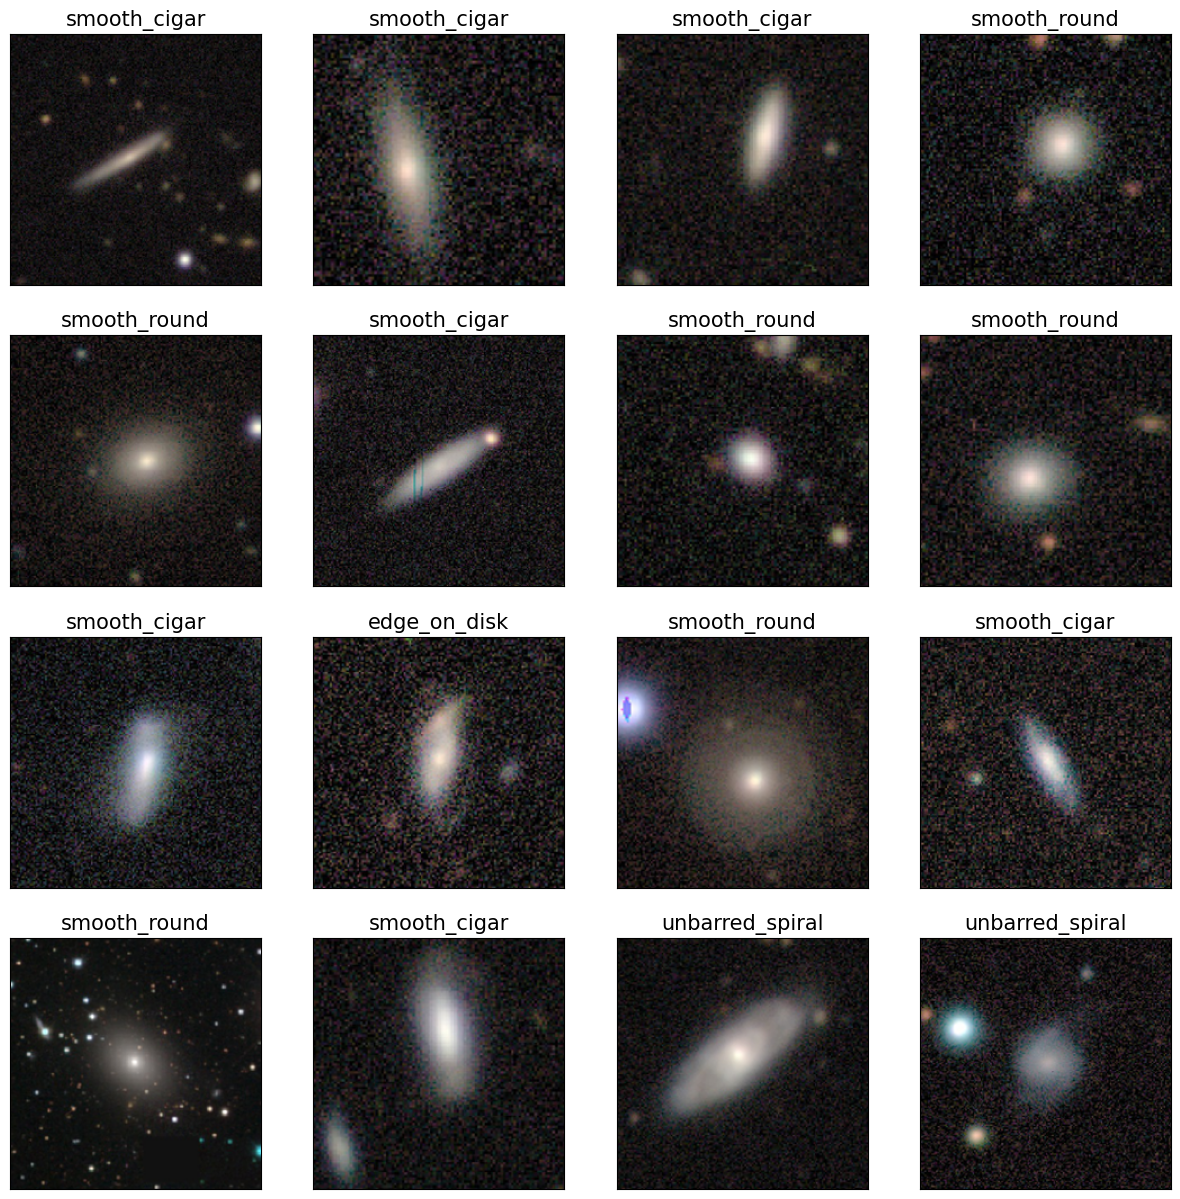

In [14]:
# - Plot images
fig = plt.figure(figsize=(15, 15))
for i, (tensor_image, target) in islice(enumerate(dataset_train), 16):
  label= dataset_train.target2label[target]  
  ax = fig.add_subplot(4, 4, i+1)
  ax.set_xticks([]); ax.set_yticks([])
  im= ax.imshow(tensor_image.permute(1, 2, 0))
  ax.set_title(f'{label}', size=15)
  
plt.show()

# CNN classifier
Let's now define a custom configurable CNN architecture to perform GMNIST image classification.

## Classifier class
Let's implement a class that uses the torch sequential class to define the architecture of the net. 

In [15]:
import torch
import torchvision
import torchmetrics
from tqdm import tqdm

class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.sum = 0
        self.count = 0

    def update(self, value, n=1):
        self.sum += value * n
        self.count += n

    @property
    def avg(self):
        return self.sum / self.count if self.count > 0 else 0

In [16]:
def build_custom_model(n_conv_layers, n_filters, dropout_prob, num_classes):
    """Crea un modello CNN personalizzato"""
    layers = []
    
    # Layer convoluzionali
    in_channels = 3  # RGB input
    for i in range(n_conv_layers):
        # Conv + ReLU + BatchNorm + MaxPool
        layers.append(torch.nn.Conv2d(
            in_channels=in_channels,
            out_channels=n_filters[i],
            kernel_size=3,
            padding="same"
        ))
        layers.append(torch.nn.ReLU())
        layers.append(torch.nn.BatchNorm2d(n_filters[i]))
        layers.append(torch.nn.MaxPool2d(kernel_size=2))
        
        in_channels = n_filters[i]
    
    # Flatten + Dense + Output
    layers.append(torch.nn.Flatten())
    layers.append(torch.nn.LazyLinear(128))
    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Dropout(dropout_prob))
    layers.append(torch.nn.LazyLinear(num_classes))
    
    return torch.nn.Sequential(*layers)

In [17]:
def build_pretrained_model(arch_name, pretrained_weights, dropout_prob, num_classes):
    """Crea un modello basato su un'architettura pre-addestrata"""
    # Carica il modello base
    if arch_name == "resnet18":
        model = torchvision.models.resnet18(weights=pretrained_weights)
    elif arch_name == "resnet34":
        model = torchvision.models.resnet34(weights=pretrained_weights)
    elif arch_name == "resnet50":
        model = torchvision.models.resnet50(weights=pretrained_weights)
    else:
        raise ValueError(f"Architettura {arch_name} non supportata")
    
    # Configura la testa di classificazione
    in_features = model.fc.in_features
    model.fc = torch.nn.Sequential(
        torch.nn.Dropout(dropout_prob),
        torch.nn.Linear(in_features, num_classes)
    )
    
    return model

In [18]:
def validate(model, val_loader, criterion, epoch, epochs, acc_metric, f1_metric, device):
    """Esegue la validazione su un epoch"""
    model.eval()
    val_loss_meter = AverageMeter()
    acc_metric.reset()
    f1_metric.reset()
    
    progress_bar = tqdm(val_loader, desc=f"Epoca {epoch+1}/{epochs} [Validazione]")
    
    with torch.no_grad():
        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)
            
            outputs = model(X)
            loss = criterion(outputs, y)
            
            val_loss_meter.update(loss.item(), X.size(0))
            preds = outputs.argmax(dim=1)
            acc_metric.update(preds, y)
            f1_metric.update(preds, y)
            
            progress_bar.set_postfix(
                loss=val_loss_meter.avg
            )
    
    return val_loss_meter.avg, acc_metric.compute().item(), f1_metric.compute().item()

In [19]:
def train_model(model, train_loader, val_loader, epochs, lr, model_save_path, num_classes, device):
    """Addestra il modello"""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Metriche
    train_acc_metric = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
    train_f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)
    
    if val_loader:
        val_acc_metric = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
        val_f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)
    
    # Storico delle metriche
    history = {
        "train_loss": [], "train_acc": [], "train_f1": [],
        "val_loss": [], "val_acc": [], "val_f1": []
    }
    
    best_val_acc = 0.0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss_meter = AverageMeter()
        train_acc_metric.reset()
        train_f1_metric.reset()
        
        progress_bar = tqdm(train_loader, desc=f"Epoca {epoch+1}/{epochs} [Training]")
        
        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            outputs = model(X)
            loss = criterion(outputs, y)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Aggiorna metriche
            train_loss_meter.update(loss.item(), X.size(0))
            preds = outputs.argmax(dim=1)
            train_acc_metric.update(preds, y)
            train_f1_metric.update(preds, y)
            
            progress_bar.set_postfix(
                loss=train_loss_meter.avg,
                acc=train_acc_metric.compute().item()
            )
        
        # Salva metriche training
        train_loss = train_loss_meter.avg
        train_acc = train_acc_metric.compute().item()
        train_f1 = train_f1_metric.compute().item()
        
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)
        
        # Validazione
        val_loss, val_acc, val_f1 = 0, 0, 0
        if val_loader:
            val_loss, val_acc, val_f1 = validate(
                model, val_loader, criterion, epoch, epochs, val_acc_metric, val_f1_metric, device
            )
            
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)
            history["val_f1"].append(val_f1)
            
            # Salva il miglior modello
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                print(f"Salvando il miglior modello con accuracy di validazione: {val_acc:.4f}")
                torch.save(model.state_dict(), model_save_path.replace(".pth", "_best.pth"))
        
        # Stampa metriche
        if val_loader:
            print(f"Epoca {epoch+1}/{epochs} - "
                  f"Loss: {train_loss:.4f} (val: {val_loss:.4f}), "
                  f"Acc: {train_acc:.4f} (val: {val_acc:.4f}), "
                  f"F1: {train_f1:.4f} (val: {val_f1:.4f})")
        else:
            print(f"Epoca {epoch+1}/{epochs} - "
                  f"Loss: {train_loss:.4f}, "
                  f"Acc: {train_acc:.4f}, "
                  f"F1: {train_f1:.4f}")
    
    # Salva il modello finale
    print(f"Salvando il modello finale")
    torch.save(model.state_dict(), model_save_path)
    
    return history

In [20]:
def evaluate_model(model, test_loader, num_classes, device, model_path=None):
    """Valuta il modello sul test set"""
    # Carica il modello se specificato
    if model_path:
        model.load_state_dict(torch.load(model_path))
    
    model.eval()
    
    # Metriche
    acc_metric = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
    f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)
    cm_metric = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=num_classes, normalize="true").to(device)
    
    progress_bar = tqdm(test_loader, desc="Valutazione")
    
    with torch.no_grad():
        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)
            
            outputs = model(X)
            preds = outputs.argmax(dim=1)
            
            acc_metric.update(preds, y)
            f1_metric.update(preds, y)
            cm_metric.update(preds, y)
    
    # Calcola metriche finali
    accuracy = acc_metric.compute().item()
    f1_score = f1_metric.compute().item()
    confusion_matrix = cm_metric.compute().cpu().numpy()
    
    print(f"Test - Accuracy: {accuracy:.4f}, F1 Score: {f1_score:.4f}")
    
    return {
        "accuracy": accuracy,
        "f1_score": f1_score,
        "confusion_matrix": confusion_matrix
    }

In [21]:
class GMNISTClassifier(nn.Module):
    """Classificatore per il dataset Galaxy MNIST con architetture custom o predefinite"""
    
    def __init__(
        self,
        nn_arch="custom",
        num_classes=4,
        pretrained_weights=None,
        # Parametri per architettura custom
        n_conv_layers=3,
        n_filters=[16, 32, 64],
        dropout_prob=0.5
    ):
        """
        Inizializza il classificatore
        
        Args:
            nn_arch: Tipo di architettura ('custom', 'resnet18', 'resnet34', ecc.)
            num_classes: Numero di classi di output
            pretrained_weights: Pesi preaddestrati per modelli torchvision
            n_conv_layers: Numero di layer convoluzionali (per architettura custom)
            n_filters: Lista di filtri per layer (per architettura custom)
            dropout_prob: Probabilità di dropout
        """
        super(GMNISTClassifier, self).__init__()
        self.nn_arch = nn_arch
        self.num_classes = num_classes
        self.n_conv_layers = n_conv_layers
        self.n_filters = n_filters if isinstance(n_filters, list) else [n_filters] * n_conv_layers
        self.dropout_prob = dropout_prob
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Crea il modello
        if nn_arch == "custom":
            self.model = build_custom_model(
                self.n_conv_layers, self.n_filters, self.dropout_prob, self.num_classes
            )
        else:
            self.model = build_pretrained_model(
                nn_arch, pretrained_weights, self.dropout_prob, self.num_classes
            )
            
        # Sposta il modello sul device corretto
        self.model.to(self.device)
        print(f"Modello creato e spostato su {self.device}")

    def forward(self, x):
        return self.model(x)
    
    def train_model(
        self,
        train_loader,
        val_loader=None,
        epochs=10,
        lr=1e-4,
        model_save_path="model.pth"
    ):
        """Addestra il modello"""
        return train_model(
            self.model, train_loader, val_loader, epochs, lr, 
            model_save_path, self.num_classes, self.device
        )
    
    def evaluate(self, test_loader, model_path=None):
        """Valuta il modello sul test set"""
        return evaluate_model(
            self.model, test_loader, self.num_classes, self.device, model_path
        )

## Create dataloaders
We are going to create a dataloader for train, validation and test data.

In [22]:
###############################
##    CREATE DATA LOADERS
###############################
# - Create data loaders
torch.manual_seed(1)
batch_size= 64
dataloader_train= torch.utils.data.DataLoader(
  dataset_train, 
  batch_size=batch_size,
  shuffle=True, 
  num_workers=1
)
dataloader_imagenet_train= torch.utils.data.DataLoader(
  dataset_imagenet_train, 
  batch_size=batch_size,
  shuffle=True, 
  num_workers=1
)

dataloader_val= torch.utils.data.DataLoader(
  dataset_val, 
  batch_size=batch_size,
  shuffle=False, 
  num_workers=1
)
dataloader_imagenet_val= torch.utils.data.DataLoader(
  dataset_imagenet_val, 
  batch_size=batch_size,
  shuffle=False, 
  num_workers=1
)

dataloader_test= torch.utils.data.DataLoader(
  dataset_test, 
  batch_size=8,
  shuffle=False, 
  num_workers=1
)
dataloader_imagenet_test= torch.utils.data.DataLoader(
  dataset_imagenet_test, 
  batch_size=8,
  shuffle=False, 
  num_workers=1
)

# - Test min/max
imgs, targets = next(iter(dataloader_test))
print("type(imgs)")
print(type(imgs))
print("imgs.shape")
print(imgs.shape)

data_min= torch.amin(imgs, dim=(2,3))
data_max= torch.amax(imgs, dim=(2,3))
data_absmax= torch.amax(imgs, dim=(1,2,3))
print("min: ", data_min)
print("max: ", data_max)
print("absmax: ", data_absmax)

/tmp/ipykernel_96326/195478787.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond = np.isfinite(img).bool()


type(imgs)
<class 'torch.Tensor'>
imgs.shape
torch.Size([8, 3, 224, 224])
min:  tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
max:  tensor([[0.9167, 0.8810, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 0.9921, 0.9206],
        [1.0000, 0.9765, 0.9412],
        [1.0000, 0.9333, 0.8784],
        [1.0000, 1.0000, 0.9843],
        [1.0000, 0.9882, 0.9373],
        [1.0000, 0.9630, 0.9259]])
absmax:  tensor([1., 1., 1., 1., 1., 1., 1., 1.])


## Create classifier
Let's create an instance of the classifier class created above. Change the "nn_arch" architecture and relative parameters to customize the network. We will create two classifiers:

- custom CNN architecture
- resnet18 architecture

### Custom architecture

In [23]:
from torchsummary import summary
# - Create classifier
logger.info("Create custom net classifier ...")
nn_arch= "custom"

classifier= GMNISTClassifier(
  nn_arch=nn_arch,
  n_conv_layers= 3,
  n_filters= [8,16,32],
  dropout_prob = 0.5
)

# - Print architecture
logger.info("Printing model arch ...")
summary(classifier, (imgs.shape[1],imgs.shape[2],imgs.shape[3]))

2025-03-14 18:03:18 INFO - Create custom net classifier ...
2025-03-14 18:03:19 INFO - Printing model arch ...


Modello creato e spostato su cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             224
              ReLU-2          [-1, 8, 224, 224]               0
       BatchNorm2d-3          [-1, 8, 224, 224]              16
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,168
              ReLU-6         [-1, 16, 112, 112]               0
       BatchNorm2d-7         [-1, 16, 112, 112]              32
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,640
             ReLU-10           [-1, 32, 56, 56]               0
      BatchNorm2d-11           [-1, 32, 56, 56]              64
        MaxPool2d-12           [-1, 32, 28, 28]               0
          Flatten-13                [-1, 25088]               0
      

### Resnet architecture

In [24]:
from torchsummary import summary
# - Create classifier
logger.info("Create Resnet classifier ...")
nn_arch= "resnet18"
pretrained_weights="DEFAULT"
classifier_resnet= GMNISTClassifier(
  nn_arch=nn_arch,
  pretrained_weights=pretrained_weights 
)

# - Print architecture
logger.info("Printing model arch ...")
summary(classifier_resnet, (imgs.shape[1],imgs.shape[2],imgs.shape[3]))

2025-03-14 18:03:19 INFO - Create Resnet classifier ...
2025-03-14 18:03:20 INFO - Printing model arch ...


Modello creato e spostato su cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
      

### Set training parameters

In [25]:
# - Set train parameters
lr= 1e-4
num_epochs= 10

### W&B Login
Let's initialize weights & biases so that we can monitor "live" some information (e.g. losses, accuracies and other metrics) for our training run. For this to work you need to have a wandb account and have set this environment variable on your system: `WANDB_API_KEY`

# Potremmo preparare un wandb e far loggare su progetti separati con apikey comune
project_name = f"workshop_{username}"

wandb.init(project=project_name, entity="tuo_team")

In [26]:
# - Initialize wandb
import os
import shortuuid
import wandb

logger.info("Initialize wandb ...")

wandb_api_key= "ed94c4019bc69f5f85e3ea0c21020b8fa194d1b0"
log_to_wandb= True
if 'WANDB_API_KEY' in os.environ:
  wandb_api_key= os.environ['WANDB_API_KEY']
  if wandb_api_key=="":
    logger.warning("WANDB_API_KEY environment variable read is empty, wont log run metrics!")
else:
  logger.warning("WANDB_API_KEY environment variable is not defined, wont log run metrics!")

if wandb_api_key!="":
  logger.info("WANDB_API_KEY is defined and not empty...trying login...")
  try:
    wandb.login()
    log_to_wandb= True
  except Exception as e:
    logger.warning("Failed to login to wandb (err=%s), won't log run metrics..." % (str(e)))
    log_to_wandb= False

2025-03-14 18:03:21 INFO - Initialize wandb ...
2025-03-14 18:03:21 WARNING - WANDB_API_KEY environment variable is not defined, wont log run metrics!
2025-03-14 18:03:21 INFO - WANDB_API_KEY is defined and not empty...trying login...
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: thomas-cecconello-inaf (ssl-inaf) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Train classifier
Let's train the classifier using architecture and parameters defined above.

### Custom architecture 

Initialize W&B for this run.

In [27]:
# - Init wandb run
if log_to_wandb:
  logger.info("Initializing wandb for this run ...")  
  os.environ['WANDB_NOTEBOOK_NAME'] = 'gmnist_classifier'
    
  run_id= shortuuid.uuid()
  run_name= "customnet_lr" + str(lr) + "_nepochs" + str(num_epochs)
  wandb_run= wandb.init(
    project=os.environ['WANDB_NOTEBOOK_NAME'],
    id=run_id,
    name=run_name,
    config={
      "batch_size": batch_size,
      "learning_rate": lr,
      "nepochs": num_epochs,  
      "dataset": "GMNIST",
    }
  ) 

2025-03-14 18:03:21 INFO - Initializing wandb for this run ...


Start the training.

In [28]:
# - Open W&B display
if log_to_wandb:
  wandb_run.display(height=720)    

# - Run train
torch.manual_seed(1)
metric_hist= classifier.train_model(
  train_loader=dataloader_train,
  val_loader=dataloader_val,  
  epochs=num_epochs,  
  lr=lr,
  model_save_path="model.pth"
)

print("metrics")
print(metric_hist)

# - Terminate wandb
if log_to_wandb and wandb.run is not None:
  logger.info("Terminating wandb ...")
  wandb.finish()

/home/thomas/miniconda3/envs/workshop/lib/python3.9/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Epoca 1/10 [Training]:   0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_96326/195478787.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond = np.isfinite(img).bool()
Epoca 1/10 [Validazione]:   0%|          | 0/38 [00:00<?, ?it/s]/tmp/ipykernel_96326/195478787.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond = np.isfinite(img).bool()
Epoca 1/10 [Validazione]: 100%|██████████| 38/38 [00:12<00:00,  3.16it/s, loss=1.02]


Salvando il miglior modello con accuracy di validazione: 0.5846
Epoca 1/10 - Loss: 1.2488 (val: 1.0203), Acc: 0.4336 (val: 0.5846), F1: 0.4317 (val: 0.5811)


Epoca 2/10 [Training]:   0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_96326/195478787.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond = np.isfinite(img).bool()
Epoca 2/10 [Validazione]:   0%|          | 0/38 [00:00<?, ?it/s]/tmp/ipykernel_96326/195478787.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond = np.isfinite(img).bool()
Epoca 2/10 [Validazione]: 100%|██████████| 38/38 [00:12<00:00,  3.12it/s, loss=0.89] 


Salvando il miglior modello con accuracy di validazione: 0.6500
Epoca 2/10 - Loss: 1.1035 (val: 0.8902), Acc: 0.5232 (val: 0.6500), F1: 0.5231 (val: 0.6479)


Epoca 3/10 [Training]:   0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_96326/195478787.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond = np.isfinite(img).bool()
Epoca 3/10 [Validazione]:   0%|          | 0/38 [00:00<?, ?it/s]/tmp/ipykernel_96326/195478787.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond = np.isfinite(img).bool()
Epoca 3/10 [Validazione]: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s, loss=0.925]


Epoca 3/10 - Loss: 0.9903 (val: 0.9251), Acc: 0.5739 (val: 0.6071), F1: 0.5729 (val: 0.6073)


Epoca 4/10 [Training]:   0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_96326/195478787.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond = np.isfinite(img).bool()
Epoca 4/10 [Validazione]:   0%|          | 0/38 [00:00<?, ?it/s]/tmp/ipykernel_96326/195478787.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond = np.isfinite(img).bool()
Epoca 4/10 [Validazione]: 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, loss=0.863]


Epoca 4/10 - Loss: 0.9327 (val: 0.8628), Acc: 0.5950 (val: 0.6454), F1: 0.5950 (val: 0.6502)


Epoca 5/10 [Training]:   0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_96326/195478787.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond = np.isfinite(img).bool()
Epoca 5/10 [Validazione]:   0%|          | 0/38 [00:00<?, ?it/s]/tmp/ipykernel_96326/195478787.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond = np.isfinite(img).bool()
Epoca 5/10 [Validazione]: 100%|██████████| 38/38 [00:11<00:00,  3.43it/s, loss=0.781]


Salvando il miglior modello con accuracy di validazione: 0.6733
Epoca 5/10 - Loss: 0.8886 (val: 0.7805), Acc: 0.6212 (val: 0.6733), F1: 0.6202 (val: 0.6662)


Epoca 6/10 [Training]:   0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_96326/195478787.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond = np.isfinite(img).bool()
Epoca 6/10 [Validazione]:   0%|          | 0/38 [00:00<?, ?it/s]/tmp/ipykernel_96326/195478787.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond = np.isfinite(img).bool()
Epoca 6/10 [Validazione]: 100%|██████████| 38/38 [00:10<00:00,  3.51it/s, loss=0.774]


Salvando il miglior modello con accuracy di validazione: 0.6821
Epoca 6/10 - Loss: 0.8558 (val: 0.7740), Acc: 0.6313 (val: 0.6821), F1: 0.6308 (val: 0.6762)


Epoca 7/10 [Training]:   0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_96326/195478787.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond = np.isfinite(img).bool()
Epoca 7/10 [Validazione]:   0%|          | 0/38 [00:00<?, ?it/s]/tmp/ipykernel_96326/195478787.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond = np.isfinite(img).bool()
Epoca 7/10 [Validazione]: 100%|██████████| 38/38 [00:10<00:00,  3.58it/s, loss=0.724]


Salvando il miglior modello con accuracy di validazione: 0.6938
Epoca 7/10 - Loss: 0.8536 (val: 0.7244), Acc: 0.6393 (val: 0.6938), F1: 0.6385 (val: 0.6926)


Epoca 8/10 [Training]:   0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_96326/195478787.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond = np.isfinite(img).bool()
Epoca 8/10 [Validazione]:   0%|          | 0/38 [00:00<?, ?it/s]/tmp/ipykernel_96326/195478787.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond = np.isfinite(img).bool()
Epoca 8/10 [Validazione]: 100%|██████████| 38/38 [00:10<00:00,  3.49it/s, loss=0.691]


Salvando il miglior modello con accuracy di validazione: 0.7033
Epoca 8/10 - Loss: 0.8211 (val: 0.6912), Acc: 0.6439 (val: 0.7033), F1: 0.6426 (val: 0.7013)


Epoca 9/10 [Training]:   0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_96326/195478787.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond = np.isfinite(img).bool()
Epoca 9/10 [Validazione]:   0%|          | 0/38 [00:00<?, ?it/s]/tmp/ipykernel_96326/195478787.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond = np.isfinite(img).bool()
Epoca 9/10 [Validazione]: 100%|██████████| 38/38 [00:11<00:00,  3.44it/s, loss=0.663]


Salvando il miglior modello con accuracy di validazione: 0.7217
Epoca 9/10 - Loss: 0.7947 (val: 0.6634), Acc: 0.6552 (val: 0.7217), F1: 0.6538 (val: 0.7226)


Epoca 10/10 [Training]:   0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_96326/195478787.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond = np.isfinite(img).bool()
Epoca 10/10 [Validazione]:   0%|          | 0/38 [00:00<?, ?it/s]/tmp/ipykernel_96326/195478787.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond = np.isfinite(img).bool()
Epoca 10/10 [Validazione]: 100%|██████████| 38/38 [00:10<00:00,  3.49it/s, loss=0.672]
2025-03-14 18:15:52 INFO - Terminating wandb ...


Epoca 10/10 - Loss: 0.7948 (val: 0.6725), Acc: 0.6548 (val: 0.7171), F1: 0.6542 (val: 0.7154)
Salvando il modello finale
metrics
{'train_loss': [1.2488167585645402, 1.1034993158067976, 0.9903234257016863, 0.9326761225291661, 0.8885730631010873, 0.8558167321341378, 0.8536348448480878, 0.821120959350041, 0.79470287833895, 0.7948283815383911], 'train_acc': [0.4335714280605316, 0.5232142806053162, 0.5739285945892334, 0.5950000286102295, 0.6212499737739563, 0.6312500238418579, 0.6392857432365417, 0.643928587436676, 0.6551785469055176, 0.6548214554786682], 'train_f1': [0.4316751956939697, 0.5231019258499146, 0.572890043258667, 0.5949686765670776, 0.6201667785644531, 0.6308162212371826, 0.6384557485580444, 0.6426275372505188, 0.6537773609161377, 0.6541563272476196], 'val_loss': [1.020278397401174, 0.8901716955502827, 0.9250595768292745, 0.8627758042017619, 0.7805082233746846, 0.7739603281021118, 0.7243598755200704, 0.6911504495143891, 0.6634161253770192, 0.6724577025572459], 'val_acc': [0.584

Let's plot some metrics after the training run completed.

2025-03-14 18:18:47 INFO - Plotting train run metrics ...


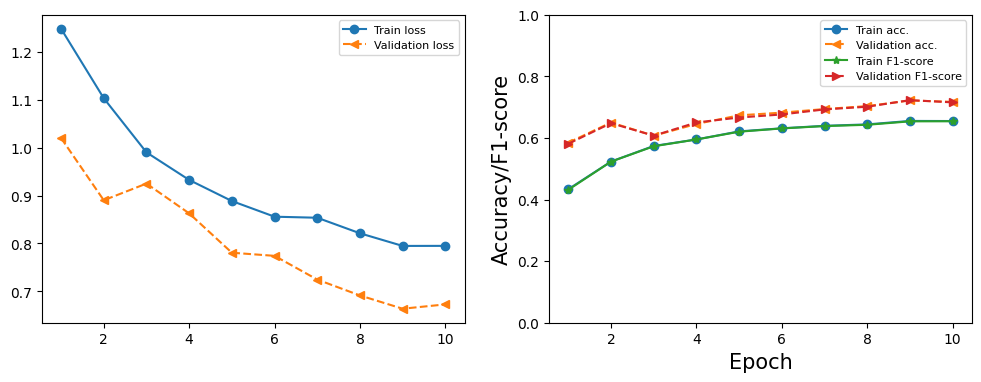

In [38]:
import matplotlib.pyplot as plt

def draw_metric_hist(metric_hist):
  
  # - Draw losses
  x_arr = np.arange(len(metric_hist["train_loss"])) + 1
  fig = plt.figure(figsize=(12, 4))
  ax = fig.add_subplot(1, 2, 1)
  ax.plot(x_arr, metric_hist["train_loss"], '-o', label='Train loss')
  ax.plot(x_arr, metric_hist["val_loss"], '--<', label='Validation loss')
    
  ax.legend(fontsize=8)
  ax = fig.add_subplot(1, 2, 2)
  
  # - Draw accuracy/f1score
  ax.set_ylim(0,1)  
  #plt.setp(ax, ylim=ax[0,0].get_ylim())  
  ax.plot(x_arr, metric_hist["train_acc"], '-o', label='Train acc.')
  ax.plot(x_arr, metric_hist["val_acc"], '--<', label='Validation acc.')
  ax.plot(x_arr, metric_hist["train_f1"], '-*', label='Train F1-score')
  ax.plot(x_arr, metric_hist["val_f1"], '-->', label='Validation F1-score')  
  ax.legend(fontsize=8)
  ax.set_xlabel('Epoch', size=15)
  ax.set_ylabel('Accuracy/F1-score', size=15)

  plt.show()  
    
logger.info("Plotting train run metrics ...")
draw_metric_hist(metric_hist)

### Resnet architecture

Initialize W&B for this run.

In [ ]:
# - Init wandb run
if log_to_wandb:
  logger.info("Initializing wandb for this run ...")  
  os.environ['WANDB_NOTEBOOK_NAME'] = 'gmnist_classifier'
    
  run_id= shortuuid.uuid()
  run_name= "resnet_lr" + str(lr) + "_nepochs" + str(num_epochs)
  wandb_run= wandb.init(
    project="gmnist-classifier",
    id=run_id,
    name=run_name,
    config={
      "batch_size": batch_size,
      "learning_rate": lr,
      "nepochs": num_epochs,  
      "dataset": "GMNIST",
    }
  )  

Start the training.

In [ ]:
# - Open W&B display
if log_to_wandb:
  wandb_run.display(height=720)  

# - Run train
torch.manual_seed(1)
metric_hist_resnet= classifier_resnet.run_train(
  train_dl=dataloader_imagenet_train,
  val_dl=dataloader_imagenet_val,  
  num_epochs=num_epochs,  
  lr=lr,
  log_to_wandb=log_to_wandb,
  outfile_prefix="resnet_model"
)

print("metrics")
print(metric_hist_resnet)

# - Terminate wandb
if log_to_wandb and wandb.run is not None:
  logger.info("Terminating wandb ...")
  wandb.finish()

Let's plot some metrics after the training run completed.

In [ ]:
logger.info("Plotting train run metrics ...")
draw_metric_hist(metric_hist_resnet)

## Test model
Let's load the saved trained model and run inference on test data. 

### Custom architecture

In [ ]:
# - Run inference on test set
logger.info("Running inference on test data ...")
metrics_test= classifier.run_test(
  dataloader=dataloader_test,
  weightfile="model_weights.pth"  
)

print("--> metrics (TEST)")
print(metrics_test)

# - Draw confusion matrix
logger.info("Drawing confusion matrix for test set ...")
fig_, ax_ = metrics_test["cm_metric"].plot()

Let's plot the gradCAM to inspect model predictions

In [ ]:
# - Run gradCAM on some test data
logger.info("Running gradCAM on test data ...")
target_layers= ["relu3"]
classifier.plot_sample_predictions(
  dataset=dataset_test,
  dataset_gradcam=dataset_test,
  weightfile="model_weights.pth", 
  plot_gradcam=True,
  layer_names=target_layers,
  gradcam_method="gradcam",
  aug_smooth=False,
  eigen_smooth=False,
  gradcam_alpha=0.5,
  apply_heatmap_thr=True,
  heatmap_thr=0.1 
)

### Resnet architecture

In [ ]:
# - Run inference on test set
logger.info("Running inference on test data ...")
metrics_resnet_test= classifier_resnet.run_test(
  dataloader=dataloader_imagenet_test,
  weightfile="resnet_model_weights.pth"  
)

print("--> metrics (TEST)")
print(metrics_resnet_test)

# - Draw confusion matrix
logger.info("Drawing confusion matrix for test set ...")
fig_, ax_ = metrics_resnet_test["cm_metric"].plot()

Let's plot the gradCAM to inspect model predictions

In [ ]:
# - Run gradCAM on some test data
logger.info("Running gradCAM on test data ...")
target_layers= ["layer4"]
classifier_resnet.plot_sample_predictions(
  dataset=dataset_imagenet_test,
  dataset_gradcam=dataset_test,
  weightfile="resnet_model_weights.pth", 
  plot_gradcam=True,
  layer_names=target_layers,
  gradcam_method="gradcam",
  aug_smooth=False,
  eigen_smooth=False,
  gradcam_alpha=0.3,
  apply_heatmap_thr=True,
  heatmap_thr=0.5 
)